# Part 2: Understanding Ford GoBike User Behavior
## by Yazan Al-Sedih
---

## Investigation Overview

The goal of this presentation is to highlight the key findings discovered from analyzing the Ford GoBike trip data and to understand user behavior and trip patterns across the bike-sharing network.  
We start with an **executive summary** to quickly convey the main insights to the audience.

**Key Insights:**
- Most Subscribers take shorter and more frequent trips compared to Customers.  
- There are noticeable differences in trip patterns between males and females, especially in terms of duration and frequency.  
- Bike usage varies across days of the week and hours of the day, with some periods being busier than others.  
- Certain stations serve as major starting or ending points for trips, indicating their importance in the bike-sharing network.  

---

## Dataset Overview and Executive Summary

The dataset contains information about Ford GoBike trips, including trip duration, start and end times, user type, gender, age, and the locations of start and end stations.  

**Summary of Findings Supported by Visualizations:**
1. Trip duration varies by user type, gender, and day of the week.  
2. Subscribers take trips more regularly than Customers.  
3. Males and females show clear differences in trip duration and frequency.  
4. Some stations are major hubs for trip starts or ends, highlighting their importance in the network.


In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [9]:
# Load the dataset into a pandas DataFrame
df = pd.read_csv("201902-fordgobike-tripdata.csv")

# Check basic info about the dataset
df.info()

# Quick summary statistics
df.describe()

# Display the first few rows to check
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183412 entries, 0 to 183411
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration_sec             183412 non-null  int64  
 1   start_time               183412 non-null  object 
 2   end_time                 183412 non-null  object 
 3   start_station_id         183215 non-null  float64
 4   start_station_name       183215 non-null  object 
 5   start_station_latitude   183412 non-null  float64
 6   start_station_longitude  183412 non-null  float64
 7   end_station_id           183215 non-null  float64
 8   end_station_name         183215 non-null  object 
 9   end_station_latitude     183412 non-null  float64
 10  end_station_longitude    183412 non-null  float64
 11  bike_id                  183412 non-null  int64  
 12  user_type                183412 non-null  object 
 13  member_birth_year        175147 non-null  float64
 14  memb

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,52185,2019-02-28 17:32:10.1450,2019-03-01 08:01:55.9750,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984.0,Male,No
1,42521,2019-02-28 18:53:21.7890,2019-03-01 06:42:03.0560,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,81.0,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaN,NaN,No
2,61854,2019-02-28 12:13:13.2180,2019-03-01 05:24:08.1460,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972.0,Male,No
3,36490,2019-02-28 17:54:26.0100,2019-03-01 04:02:36.8420,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989.0,Other,No
4,1585,2019-02-28 23:54:18.5490,2019-03-01 00:20:44.0740,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974.0,Male,Yes


In [13]:
# -----------------------------
# Data Cleaning and Preparation
# -----------------------------

# 1. Convert start_time and end_time to datetime
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

# 2. Extract useful time features for analysis
df['start_hour'] = df['start_time'].dt.hour
df['start_day_of_week'] = df['start_time'].dt.day_name()
df['start_month'] = df['start_time'].dt.month

# 3. Calculate age based on birth year
current_year = 2019  # since dataset is Feb 2019
df['age'] = current_year - df['member_birth_year']

# 4. Handle missing or null values
df['member_gender'] = df['member_gender'].fillna('Unknown')  # Fill missing gender
median_age = df['age'].median()
df['age'] = df['age'].fillna(median_age)  # Fill missing ages with median

# 5. Remove unrealistic or invalid data
df = df[df['duration_sec'] > 0]  # Remove trips with non-positive duration
df = df[(df['age'] >= 10) & (df['age'] <= 100)]  # Filter unrealistic ages

# 6. Optional: reset index after filtering
df.reset_index(drop=True, inplace=True)

# 7. Quick check of cleaned data
print(df.info())
print(df.head())

# 8. Save cleaned dataframe to a new CSV file for future use
df.to_csv("fordgobike_tripdata_cleaned.csv", index=False)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183340 entries, 0 to 183339
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   duration_sec             183340 non-null  int64         
 1   start_time               183340 non-null  datetime64[ns]
 2   end_time                 183340 non-null  datetime64[ns]
 3   start_station_id         183143 non-null  float64       
 4   start_station_name       183143 non-null  object        
 5   start_station_latitude   183340 non-null  float64       
 6   start_station_longitude  183340 non-null  float64       
 7   end_station_id           183143 non-null  float64       
 8   end_station_name         183143 non-null  object        
 9   end_station_latitude     183340 non-null  float64       
 10  end_station_longitude    183340 non-null  float64       
 11  bike_id                  183340 non-null  int64         
 12  user_type       

## Visualization 1: Trips by User Type

In this step, we explore how trips are distributed across different user types.  
This visualization helps us identify which group relies more heavily on the bike-sharing service and provides insight into user behavior patterns.


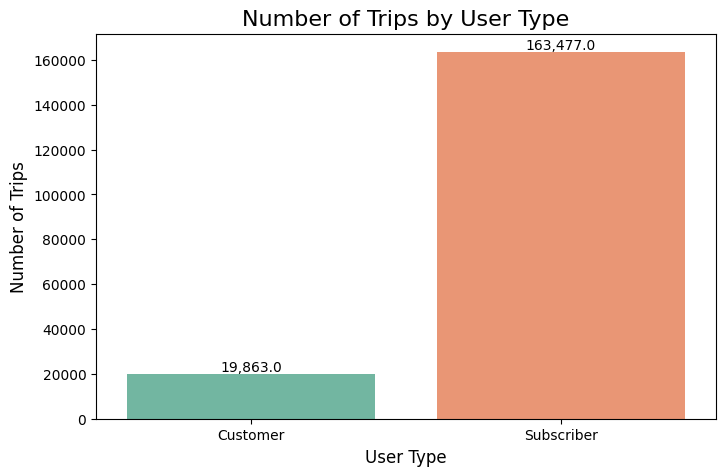

In [14]:
# -----------------------------
# Visualization 1: Trips by User Type
# -----------------------------

plt.figure(figsize=(8,5))

# Count of trips per user type
sns.countplot(data=df, x='user_type', palette='Set2')

# Add title and labels
plt.title('Number of Trips by User Type', fontsize=16)
plt.xlabel('User Type', fontsize=12)
plt.ylabel('Number of Trips', fontsize=12)

# Show counts on top of bars
for p in plt.gca().patches:
    plt.gca().annotate(format(p.get_height(), ','),
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center',
                       xytext=(0, 5),
                       textcoords='offset points')

plt.show()


### Observations:

- **Subscribers dominate usage**: With 163,477 trips (89.2%), 
  subscribers account for nearly 9 out of every 10 trips in the system.
  
- **Customer usage is minimal**: Customers made only 19,863 trips (10.8%), 
  suggesting the service is primarily used by regular commuters rather than 
  casual or tourist riders.
  
- **Business implication**: The heavy reliance on subscribers indicates 
  a stable, predictable revenue stream and suggests that marketing efforts 
  should focus on converting occasional users into subscribers.
  
- **Insight**: This 89-11 split suggests Ford GoBike has successfully 
  built a loyal subscriber base, but there's untapped potential in the 
  customer segment that could be explored through targeted campaigns.

## Visualization 2: Trip Duration by User Type

In this visualization, we examine the distribution of trip durations for Subscribers and Customers. 
The goal is to compare how long each user type typically rides, which provides insight into usage patterns and behavior differences between casual and regular users.


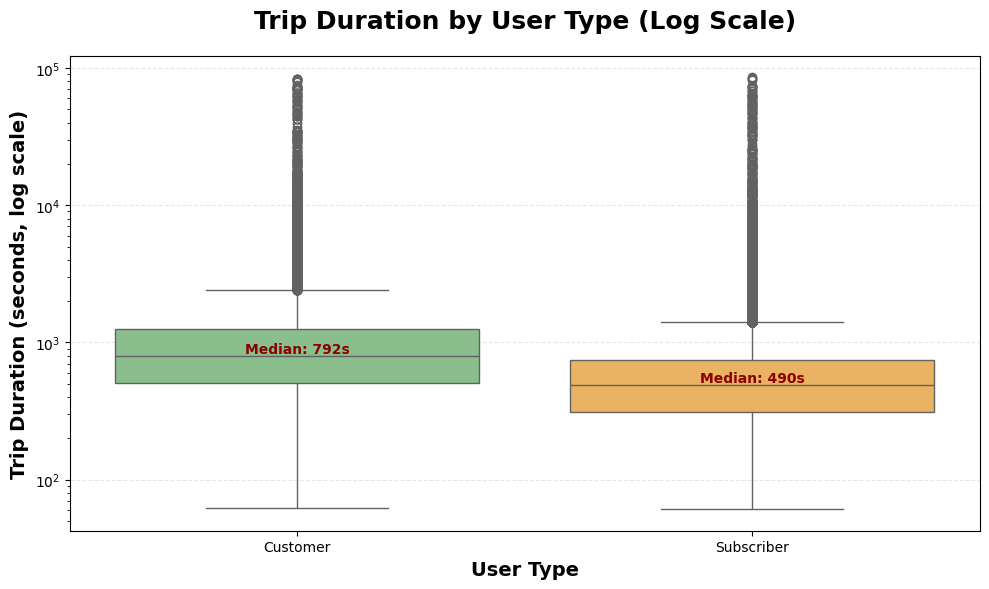

In [17]:
# -----------------------------
# Visualization 2: Trip Duration by User Type
# -----------------------------

plt.figure(figsize=(10, 6))

# Use a log scale for duration to handle long-tail distribution
ax = sns.boxplot(data=df, x='user_type', y='duration_sec', 
                 palette=['#81c784', '#ffb74d'])  # Custom colors
plt.yscale('log')

# Add title and labels with better formatting
plt.title('Trip Duration by User Type (Log Scale)', 
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel('User Type', fontsize=14, fontweight='bold')
plt.ylabel('Trip Duration (seconds, log scale)', fontsize=14, fontweight='bold')

# Add median values as annotations
medians = df.groupby('user_type')['duration_sec'].median()
positions = range(len(medians))
for pos, (user_type, median_val) in enumerate(medians.items()):
    plt.text(pos, median_val, f'Median: {int(median_val)}s', 
             ha='center', va='bottom', fontsize=10, 
             fontweight='bold', color='darkred')

# Add grid for better readability
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

### Observations:
- **Duration patterns differ significantly**: Customers take longer trips 
  with a median duration of 792 seconds (≈13 minutes), while Subscribers 
  take shorter trips with a median of 490 seconds (≈8 minutes) - 
  nearly 60% shorter.
  
- **Outliers are present in both groups**: The log scale reveals that both user 
  types have extreme outliers reaching up to 24+ hours, but these are rare 
  cases that likely represent unreturned bikes or data anomalies.
  
- **Usage behavior insight**: Subscribers use bikes for quick, point-to-point 
  commutes (likely work/errands), while Customers use them for leisure or 
  exploratory rides, explaining their longer duration.
  
- **Business implication**: Pricing models should reflect this difference - 
  Subscribers benefit from unlimited short rides, while Customers might 
  need time-based pricing to account for longer usage.
  
- **Insight**: The consistent short-trip pattern among Subscribers suggests 
  efficient network design with well-placed stations for daily commuters, 
  while Customer behavior indicates potential for tourist-focused routes 
  or packages.

## Visualization 3: Trips by Hour of Day

In this visualization, we explore how trips are distributed across the hours of the day.  
The goal is to identify peak hours and understand daily usage patterns of the bike-sharing system.


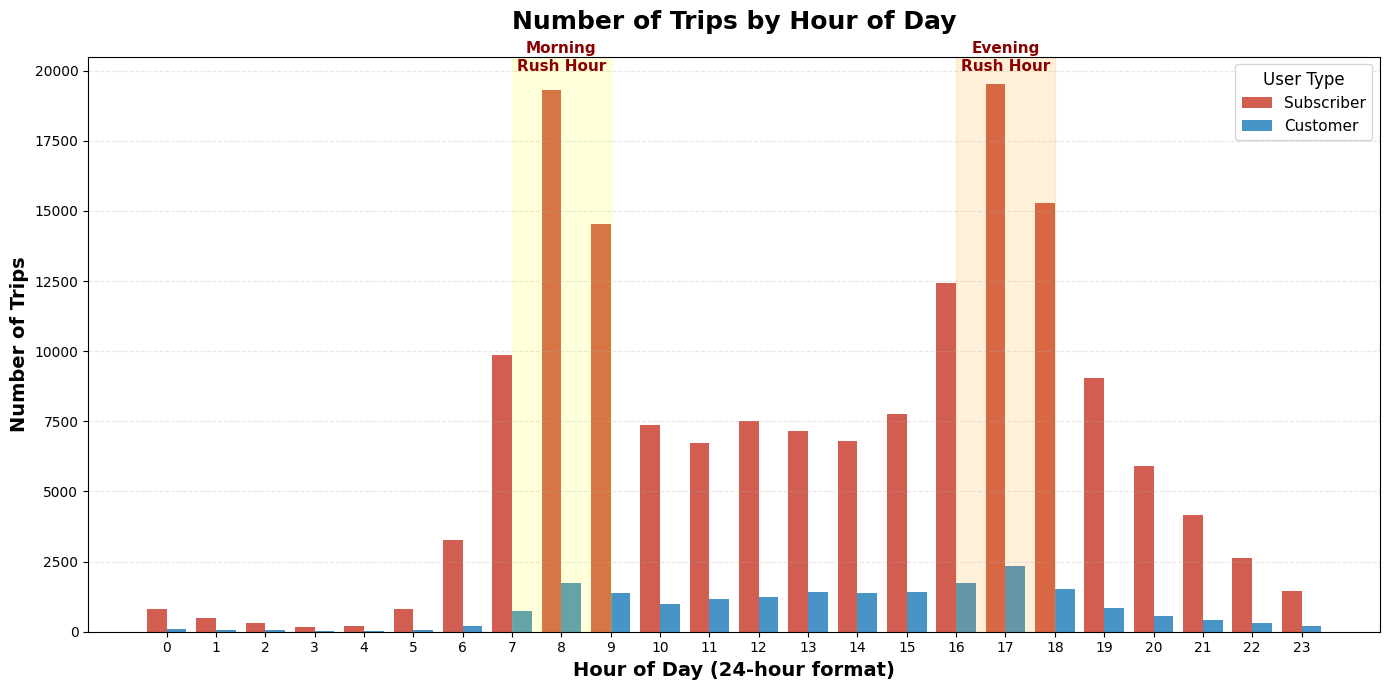

In [20]:
# -----------------------------
# Visualization 3: Trips by Hour of Day
# -----------------------------

plt.figure(figsize=(14, 7))

# Count trips by hour
sns.countplot(data=df, x='start_hour', hue='user_type', 
              palette=['#e74c3c', '#3498db'])

# Title and labels
plt.title('Number of Trips by Hour of Day', 
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Hour of Day (24-hour format)', fontsize=14, fontweight='bold')
plt.ylabel('Number of Trips', fontsize=14, fontweight='bold')

# Legend
plt.legend(title='User Type', fontsize=11, title_fontsize=12)

# Grid
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Highlight peak hours
plt.axvspan(7, 9, alpha=0.15, color='yellow')
plt.axvspan(16, 18, alpha=0.15, color='orange')

# Add simple text labels
plt.text(8, 20000, 'Morning\nRush Hour', 
         ha='center', fontsize=11, fontweight='bold', color='darkred')
plt.text(17, 20000, 'Evening\nRush Hour', 
         ha='center', fontsize=11, fontweight='bold', color='darkred')

plt.tight_layout()
plt.show()

### Observations:

- **Clear commute-hour peaks**: Subscriber usage shows dramatic spikes at 
  8 AM (~19,000 trips) and 5 PM (19,000 trips), perfectly aligning with 
  typical work commute times. These two hours alone account for a significant 
  portion of daily trips.

- **Customer behavior differs markedly**: While Subscribers dominate rush hours, 
  Customers show relatively consistent usage throughout the day (averaging 
  ~1,500-2,000 trips per hour during daylight hours), suggesting leisure and 
  exploratory usage patterns.

- **Off-peak hours reveal the difference**: Between 10 AM - 3 PM, Subscriber 
  usage drops significantly (~7,000-7,500 trips/hour), while Customer usage 
  remains steady, indicating Customers are not constrained by work schedules.

- **Late-night usage is minimal**: Both user types show very low activity 
  between midnight and 5 AM, with usage dropping below 1,000 trips/hour, 
  likely due to safety concerns and reduced demand.

- **Business implication**: Fleet management should prioritize bike availability 
  and station capacity during 7-9 AM and 4-6 PM to serve the large Subscriber 
  base. Maintenance windows should target the 1-5 AM period when demand is lowest.

- **Insight**: The bimodal distribution (two peaks) confirms Ford GoBike's 
  primary role as a commuter service. Marketing to Customers could focus on 
  midday and weekend leisure rides when Subscriber demand is lower, maximizing 
  bike utilization throughout the day.